In [13]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
from models.cnn import OneHeadResNet50Model

In [14]:
ckpt_path = 'logs/250410-120541_FeatureExtraction_Cataract101FeatureExtract_cnn_OneHeadResNet50Model/checkpoints/epoch=5-val_acc_phase=0.91.ckpt'

def load_frame(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3183, 0.2889, 0.2074],
                             std=[0.2991, 0.2494, 0.2164])
    ])
    frame = Image.open(image_path).convert('RGB')
    frame_tensor = transform(frame).unsqueeze(0)
    frame = np.array(frame.resize((224, 224)), dtype=np.float32) / 255.0
    return frame, frame_tensor


class HParams:
    def __init__(self, out_features):
        self.out_features = out_features

def main(frame_path):
    # Set up the device: use mps if available, otherwise fall back to CPU.
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
    print("Using device:", device)
    
    # model = OneHeadResNet50Model(HParams(out_features=13))
    model = OneHeadResNet50Model(HParams(out_features=10))
    checkpoint = torch.load(ckpt_path, map_location=device, weights_only=True)
    state_dict = checkpoint["state_dict"]
    new_state_dict = {}
    for key, value in state_dict.items():
        # make key name consistent 
        if key.startswith("model.model."):
            new_key = key.replace("model.model.", "model.")
        elif key.startswith("model."):
            new_key = key.replace("model.", "")
        else:
            new_key = key
        new_state_dict[new_key] = value
    # Remove irrelevant keys
    for unwanted_key in ["log_vars", "ce_loss.weight"]:
        if unwanted_key in new_state_dict:
            del new_state_dict[unwanted_key]
    # Load pretrained weights to the model
    model.load_state_dict(new_state_dict, strict=True)
    model.to(device)
    model.eval()
    
    # Run a forward pass to get the predicted class
    frame, frame_tensor = load_frame(frame_path)
    input_tensor = frame_tensor.to(device)
    with torch.no_grad():
        out_stem, phase = model(input_tensor)
    # phase = torch.softmax(phase, dim=1)
    predicted_class = torch.argmax(phase, dim=1).item()
    print("Predicted class:", predicted_class)

    #----------------------------------------------
    # Set up GradCAM
    #----------------------------------------------
    target_layer = [model.model.layer4[-1]]

    grad_cam = GradCAMPlusPlus(model=model.model, target_layers=target_layer)
    result_cam = grad_cam(input_tensor=input_tensor)
    greyscale_cam = result_cam[0, :]

    visualization = show_cam_on_image(frame, greyscale_cam, use_rgb=True)
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    # Plot the original image.
    axes[0].imshow(frame)
    axes[0].set_title("Original Image", fontsize=30)
    axes[0].axis("off")
    # Plot the GradCAM overlay.
    axes[1].imshow(visualization)
    axes[1].set_title("GradCAM Visualization", fontsize=30)
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

Using device: mps
Predicted class: 1


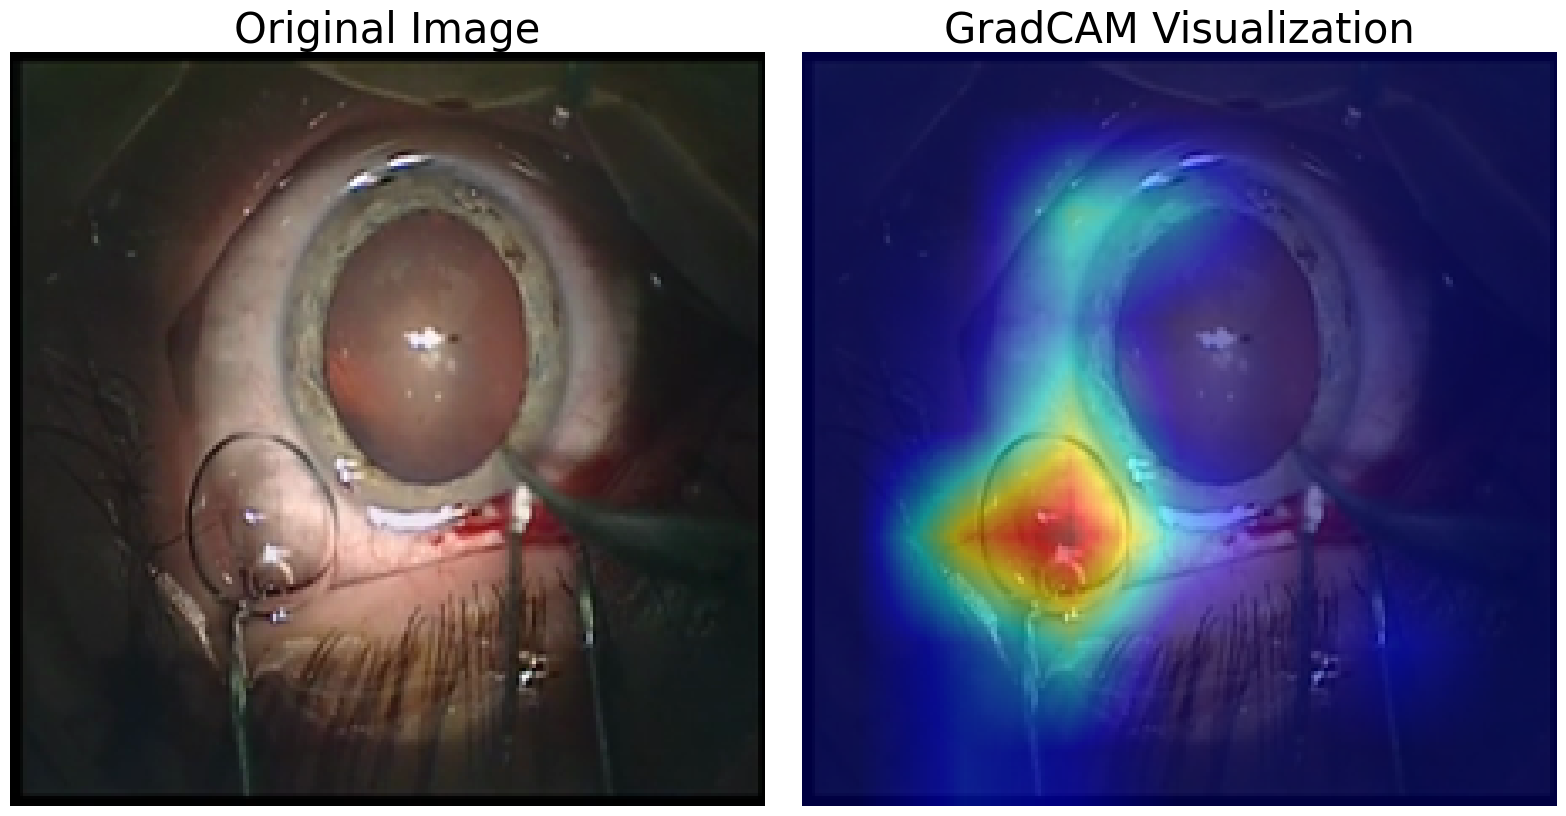

In [15]:
main("images_cataract_101/case_932/case_932_ViscousAgentInjection_1027-2379_000195.png")